In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
import statsmodels.stats.multitest as sm 
import matplotlib.colors as colors
from matplotlib.colorbar import ColorbarBase
import math

In [2]:
data_ct = pd.read_csv('<Path to effect sizes of celltypes genesets on cognitive ability when deleted and duplicated>', sep = '\t')

# Ordered list of cell types
list_ct = [
    'Layer 1', 
           'Layer 2', 
           'Layer 3', 
           'Layer 4', 
           'Layer 5', 
           'Layer 6', 
           
            'Cell In', 
            'Cell Ex',
            'Cell End',
            'Cell Mic',
            'Cell Ast', 
            'Cell OPC', 
            'Cell Oli',
    
            'Fetal_cells Mic', 
            'Fetal_cells End', 
            'Fetal_cells Per',
            'Fetal_cells PgG2M',
            'Fetal_cells PgS', 
            'Fetal_cells OPC', 
            'Fetal_cells oRG', 
            'Fetal_cells vRG',
            'Fetal_cells InMGE', 
            'Fetal_cells InCGE', 
            'Fetal_cells ExN', 
            'Fetal_cells IP',
            'Fetal_cells ExM-U',
            'Fetal_cells ExM', 
            'Fetal_cells ExDp2', 
            'Fetal_cells ExDp1', 
          ]
print(data_ct.max_score.unique())

[10000]


In [4]:
data_ct_clean = data_ct[(data_ct.cat == 'g') &
                        (data_ct.gene_list_name.isin([ct for ct in list_ct])) &
                        (data_ct.diagnosis == 'wo_ASD') &
                        (data_ct.ancestry == 'All') &
                        (data_ct.model_type == '1_3') &
                       (data_ct.max_score == 10000)]
print(data_ct_clean.shape)

print(data_ct_clean.head())

(58, 22)
                variable  Estimate        SE   tvalues    pvalue cat  win  \
54   DEL_LOEUF_gene_list -0.067849  0.016892 -4.016687  0.000059   g    1   
75   DUP_LOEUF_gene_list  0.001719  0.008142  0.211110  0.832802   g    1   
138  DEL_LOEUF_gene_list -0.032467  0.022891 -1.418354  0.156089   g    1   
159  DUP_LOEUF_gene_list -0.060732  0.013739 -4.420347  0.000010   g    1   
222  DEL_LOEUF_gene_list -0.011947  0.042615 -0.280342  0.779215   g    1   

               aic            bic model_type  ... total_carriers  \
54   719412.382643  719569.310333        1_3  ...           2644   
75   719442.964833  719599.892523        1_3  ...           7284   
138  719402.180131  719559.107821        1_3  ...           1083   
159  719441.327324  719598.255014        1_3  ...           3128   
222  719404.944844  719561.872534        1_3  ...            447   

                                              carriers  \
54   1002185_Batch_b076,1006357_Batch_b092,1007481_...   
75 

In [5]:
def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.Estimate_DEL + b*row.Estimate_DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.Estimate_DEL - row.Estimate_DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('<Path to list of normalized tagDS for each geneset sizes>', sep='\t')
    print(es_data.head())
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], left_index=True, right_on='gene_list_name', how='inner')

    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='inner')
    ztagDS = (tmp['tagDS'] - tmp['mu_s'])/ tmp['sd_s']
    return ztagDS  

('1_3', 1)
('1_3', 1)
                Estimate_DEL  Estimate_DUP  pvalue_adj_DEL  pvalue_adj_DUP  \
gene_list_name                                                               
Layer 1            -0.067849      0.001719        0.000285        0.894491   
Layer 2            -0.032467     -0.060732        0.284354        0.000071   
Layer 3            -0.011947      0.011426        0.823619        0.587360   
Layer 4            -0.043961     -0.002239        0.350158        0.898091   
Layer 5            -0.058670     -0.048226        0.124378        0.009117   

                total_carriers_DEL  total_carriers_DUP     tagDS  
gene_list_name                                                    
Layer 1                     2644.0              7284.0  0.028204  
Layer 2                     1083.0              3128.0 -0.043121  
Layer 3                      447.0              3001.0  0.015197  
Layer 4                      522.0              2198.0  0.015191  
Layer 5                      

/tmp/ipykernel_454737/1067970299.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_genes, rotation=90,ha="left", va="center",rotation_mode="anchor")


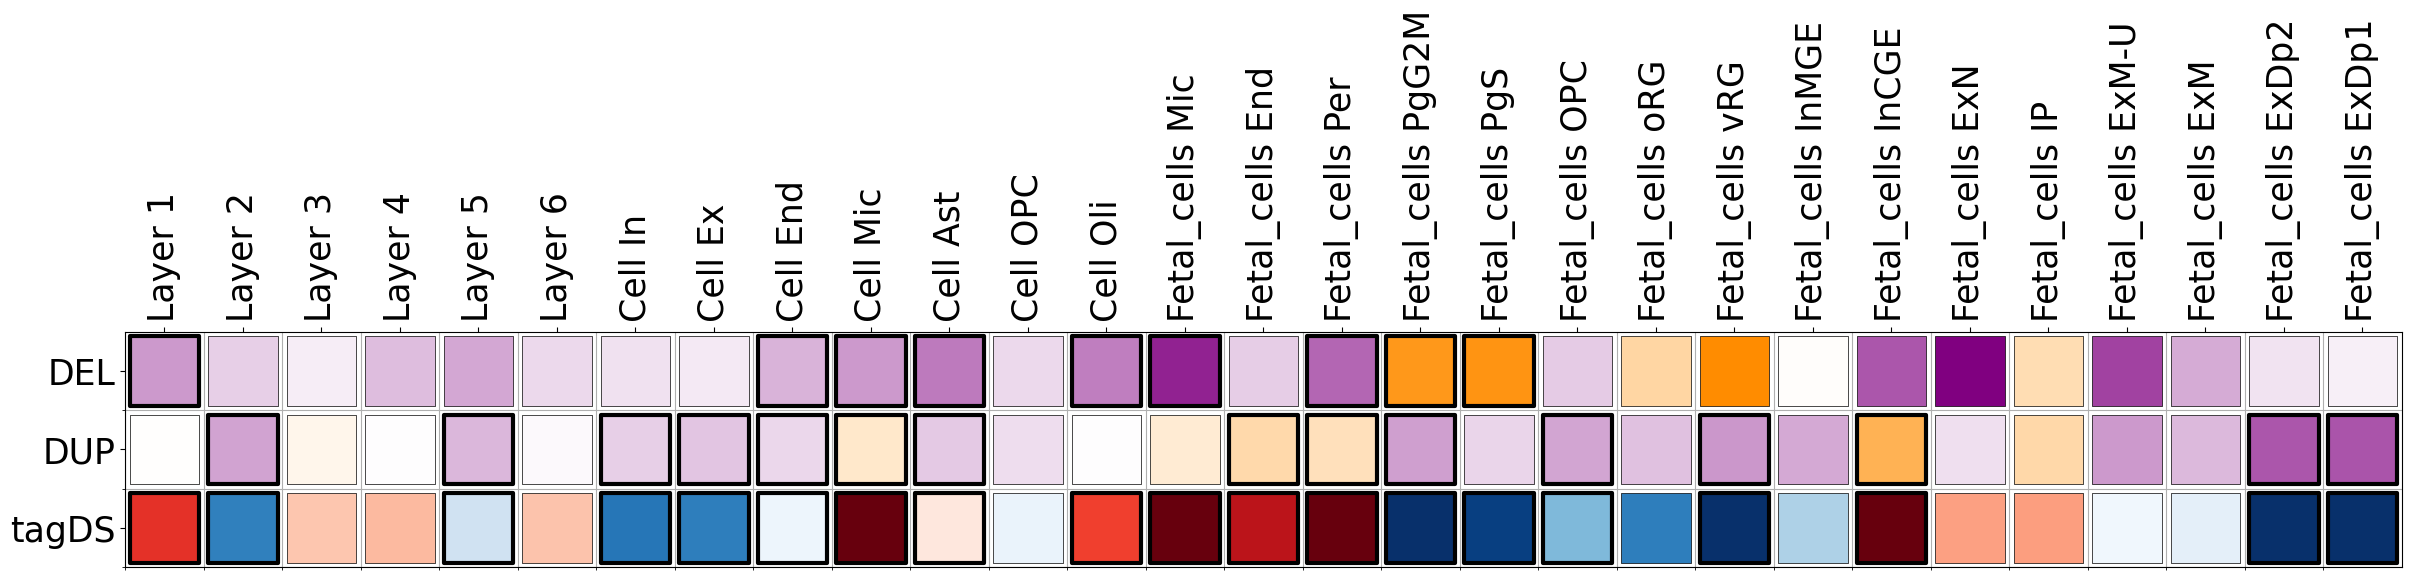

In [26]:
def plot_cell_type_hm_all(data_CNV,list_genes, ax):
    indexes = ['DEL', 'DUP']
    
    top = LinearSegmentedColormap.from_list("mycmap", ['purple',  "white"])
    bottom = LinearSegmentedColormap.from_list("mycmap", ["white", "darkorange"])
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                               bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')
    divnorm = colors.TwoSlopeNorm(vmin=data_CNV.Estimate.min(), vcenter=0, vmax=data_CNV.Estimate.max())
    
    colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
    colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
    all_colors = np.vstack((colors_dup, colors_del))
    del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)
    
    
    # data_CNV.gene_list_name = data_CNV.gene_list_name.str[:-4]
    clean_data = pd.DataFrame(data_CNV.pivot(columns='TYPE', values=['Estimate', 'pvalue_adj', 'total_carriers'], index = 'gene_list_name'))
    clean_data.columns = ['Estimate_DEL', 'Estimate_DUP', 'pvalue_adj_DEL', 'pvalue_adj_DUP',  'total_carriers_DEL', 'total_carriers_DUP'] 
    clean_data = clean_data.reindex(list_genes)
   
    ratio =  0.426609501927956
    tagDS_vals = compute_tagDS(clean_data, data_CNV, ratio)
    divnormtag = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
    
    ax.scatter(x=clean_data.index, y=['tagDS']*len(clean_data.index), c=tagDS_vals, cmap=del_dup_spe, norm=divnormtag, s=2500, marker='s', edgecolor='black', linewidth=np.where((clean_data.pvalue_adj_DUP < 0.05)|(clean_data.pvalue_adj_DEL < 0.05), 3, 0.5))
    ax.scatter(x=clean_data.index, y=['DUP']*len(clean_data.index), c=clean_data.Estimate_DUP, cmap=newcmp, norm=divnorm, s=2500, edgecolor='black', linewidth=np.where(clean_data.pvalue_adj_DUP < 0.05, 3, 0.5),marker='s')
    ax.scatter(x=clean_data.index, y=['DEL']*len(clean_data.index), c=clean_data.Estimate_DEL, cmap=newcmp, norm=divnorm, s=2500, edgecolor='black',linewidth=np.where(clean_data.pvalue_adj_DEL < 0.05, 3, 0.5),marker='s')
    
    ax.set_aspect("equal", "box")

    ax.set_xlim(-0.5, len(clean_data.index)-0.5)
    ax.set_ylim(-0.5, 3-0.5)
    ax.set_yticks(np.arange(3)-0.5, minor=True)
    print((np.arange(3)-0.5))
    ax.set_xticks(np.arange(len(clean_data.index))-0.5, minor=True)

    ax.set_xticklabels(list_genes, rotation=90,ha="left", va="center",rotation_mode="anchor")
    ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.grid(which='minor')

    
    plt.rc('font', size=25)

fig, ax = plt.subplots(figsize=(24,10), layout="constrained")
new_data_ct = pd.DataFrame()

for cnv_type in data_ct_clean.TYPE.unique():
    for combo in set(zip(data_ct_clean['model_type'], data_ct_clean['win'])):
        print(combo)
        tmp = data_ct_clean[(data_ct_clean.TYPE==cnv_type) & (data_ct_clean.model_type==combo[0]) & (data_ct_clean.win==combo[1])].copy()
        tmp['pvalue_adj'] = sm.fdrcorrection(tmp['pvalue'])[1]
        new_data_ct = pd.concat([new_data_ct, tmp])
        
plot_cell_type_hm_all(new_data_ct, list_ct, ax)
plt.show()